<a href="https://colab.research.google.com/github/alexruek/Airflow_workshop/blob/master/MLE_Uplift_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данные из экспериментов рекламной платформы Criteo. См. http://ailab.criteo.com/criteo-uplift-prediction-dataset/

Суть экспериментов - на части пользователей (контрольная группа) отключается таргетированная реклама.

В датасете содержится информация о 25M пользователях. Каждый из них описывается
* 12 признаками, зафиксированными на начало эксперимента
* флагом группы
* флагами посещения сайта рекламодателя (visit) и конверсии в покупку (conversion)

Описание полей
* f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: признаки пользователя (dense, float)
* treatment: в какой группе пользователь (1 = treated, 0 = control)
* conversion: флаг конверсии (binary, label)
* visit: флаг визита (binary, label)

# Uplift моделирование.

В ходе данного ноутбука разберем следующие моменты:
1. Поговорим о данных
2. Реализуем базовую оценку Qini-score
3. Реализуем следующие методы мета-обучения:
   - T-learner
   - X-learner
   - R-learner
4. Рассмотрим альтернативный способ реализации с помощью CasualML


## Немного о данных

## Libs

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from IPython.display import Image

In [ ]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

Failed to import duecredit due to No module named 'duecredit'


In [ ]:
from IPython.display import Image

In [ ]:
import causalml.inference.tree as ctree

In [ ]:
import causalml.inference.meta.xlearner as xlearner

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
from typing import List, Tuple

## Загрузка и подготовка данных

### Загрузка

In [ ]:
data = pd.read_csv('data/criteo-uplift-v2.1.csv.gz')

In [ ]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
data.shape

(13979592, 16)

### Подготовка данных

In [ ]:
cols_features = [
    "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"
]

col_treatment = 'treatment'

Разделим данные на обучающие и валидационные

In [ ]:
fit_index, val_index = train_test_split(data.index, test_size=0.2, random_state=165)

In [ ]:
len(fit_index)

11183673

In [ ]:
len(val_index)

2795919

Данных слишком много, возьмем первые 100_000

In [ ]:
_sample_treated_size = 100_000
_sample_control_size = 100_000
fit_sample_index = data.loc[fit_index, [col_treatment]].query(f'{col_treatment} == 1').sample(_sample_treated_size).index
fit_sample_index = fit_sample_index.union(
    data.loc[fit_index, [col_treatment]].query(f'{col_treatment} == 0').sample(_sample_control_size).index
)

In [ ]:
val_sample_index = data.loc[val_index, [col_treatment]].query(f'{col_treatment} == 1').sample(_sample_treated_size).index
val_sample_index = val_sample_index.union(
    data.loc[val_index, [col_treatment]].query(f'{col_treatment} == 0').sample(_sample_control_size).index
)

## EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [ ]:
data.nunique()

f0            2181959
f1                 60
f2            2051900
f3                552
f4                260
f5                132
f6               1645
f7             622143
f8               3743
f9               1594
f10            517372
f11               136
treatment           2
conversion          2
visit               2
exposure            2
dtype: int64

In [ ]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Как устроены treatment, visit и conversion?

In [ ]:
data['treatment'].value_counts(normalize = True)

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

In [ ]:
visit_pivot = data.groupby('treatment').agg({'visit': ['mean', 'sum', 'count']})
visit_pivot

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [ ]:
conversion_pivot = data.groupby('treatment').agg({'conversion': ['mean', 'sum', 'count']})
conversion_pivot

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [ ]:
print(f'Разница в клик-рейте между контрольной и целевой: {np.round(data.groupby("treatment")["visit"].mean()[1] - data.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Разница в конверсии между контрольной и целевой: {np.round(data.groupby("treatment")["conversion"].mean()[1] - data.groupby("treatment")["conversion"].mean()[0], 4)}')

Разница в клик-рейте между контрольной и целевой: 0.0103
Разница в конверсии между контрольной и целевой: 0.0012


### Как устроены факторы?

#### Попарные зависимости и гистограммы

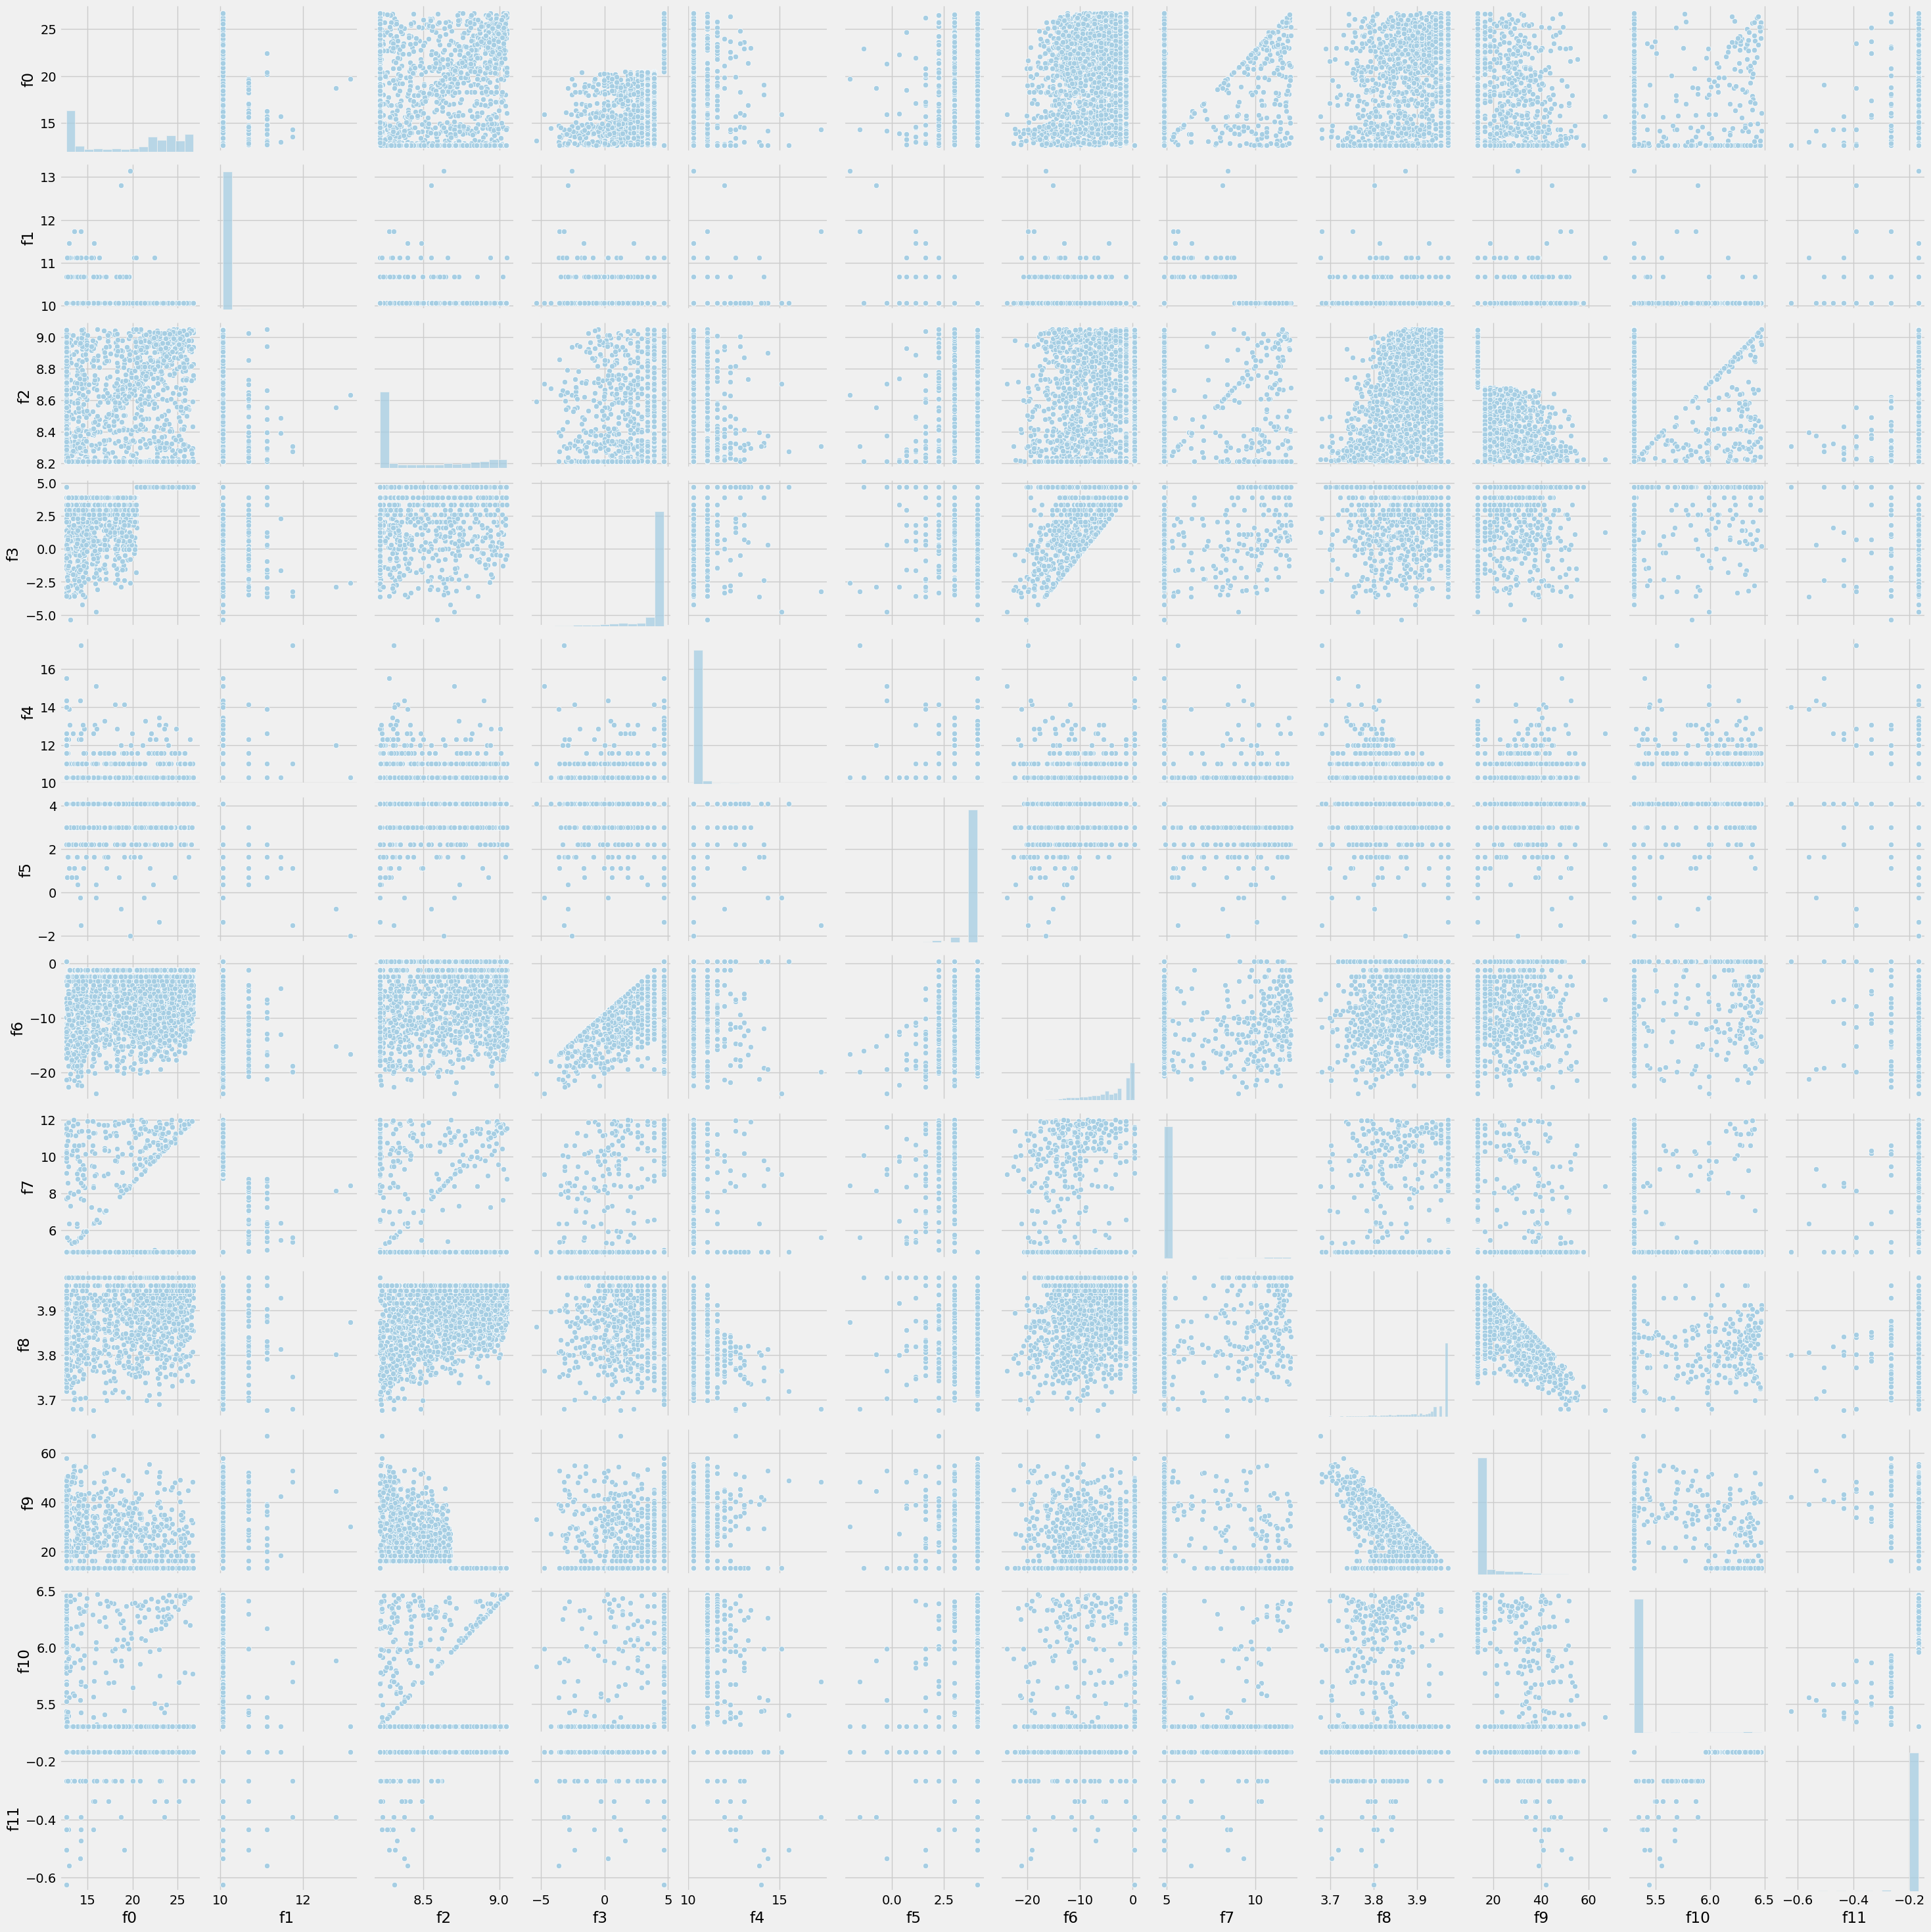

In [ ]:
sns.pairplot(data[cols_features].sample(5000))

## Experiments

### Простой Uplift

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Реализуем подсчёт Qini Score и построение графика с закрашенной областью
def calculate_qini_score(df, uplift_col, treatment_col, outcome_col):
    """
    Calculate Qini score (AUUC - area under uplift curve) for uplift modeling and plot the Qini curve.

    Parameters:
    df (pd.DataFrame): The dataframe containing treatment, outcome, and uplift predictions.
    treatment_col (str): The name of the column indicating whether the treatment was applied.
    outcome_col (str): The name of the column containing the outcome (binary).
    uplift_col (str): The name of the column containing the uplift predictions.

    Returns:
    float: The Qini score.
    """
    # Сортируем DataFrame по предсказанному uplift (по убыванию)
    df_sorted = df.sort_values(by=uplift_col, ascending=False)

    # Определяем переменные, содержащие необходимые столбцы
    treatment_sorted = df_sorted[treatment_col].values
    outcome_sorted = df_sorted[outcome_col].values

    # Подсчет количества групп
    n_treat = np.sum(treatment_sorted)
    n_control = len(treatment_sorted) - n_treat

    # Накопленные результаты по treatment и control
    cum_outcome_treat = np.cumsum(outcome_sorted * treatment_sorted)
    cum_outcome_control = np.cumsum(outcome_sorted * (1 - treatment_sorted))

    # Qini кривая
    qini_curve = cum_outcome_treat / n_treat - cum_outcome_control / n_control

    # Идеальная кривая и случайная кривая
    ideal_curve = np.sort(outcome_sorted)[::-1].cumsum() / len(outcome_sorted)
    random_curve = np.linspace(0, np.max(qini_curve), len(qini_curve))

    # Построение графика Qini кривой
    plt.figure(figsize=(10, 6))
    x_values = np.linspace(0, 1, len(qini_curve))

    # Построение кривых
    plt.plot(x_values, qini_curve, label='Uplift-модель', color='b')
    plt.plot(x_values, random_curve, label='Случайная модель', linestyle=':', color='r')

    # Закрашивание области между кривой uplift-модели и случайной моделью
    plt.fill_between(x_values, qini_curve, random_curve, where=(qini_curve > random_curve),
                     color='skyblue', alpha=0.4, label='Область между кривыми')

    plt.xlabel('% охваченных клиентов')
    plt.ylabel('Кумулятивный uplift')
    plt.title('Qini-кривая')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Подсчет Qini Score
    qini_score = np.trapz(qini_curve, dx=1/len(qini_curve)) - np.trapz(random_curve, dx=1/len(random_curve))

    return qini_score

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def calculate_uplift_at_k(df, uplift_col, treatment_col, outcome_col, k=0.3):
    """
    Calculate Uplift@k for uplift modeling.

    Parameters:
    df (pd.DataFrame): The dataframe containing treatment, outcome, and uplift predictions.
    treatment_col (str): The name of the column indicating whether the treatment was applied.
    outcome_col (str): The name of the column containing the outcome (binary).
    uplift_col (str): The name of the column containing the uplift predictions.
    k (float): The fraction (between 0 and 1) of the top customers to consider.

    Returns:
    float: The Uplift@k score.
    """
    # Проверяем, что k находится в диапазоне от 0 до 1
    if not (0 < k <= 1):
        raise ValueError("k должно быть в диапазоне (0, 1]")

    # Сортируем DataFrame по предсказанному uplift (по убыванию)
    df_sorted = df.sort_values(by=uplift_col, ascending=False)

    # Определяем количество записей, которые должны быть выбраны для расчета uplift@k
    top_k_count = int(np.ceil(len(df_sorted) * k))

    # Отбираем топ k% клиентов
    df_top_k = df_sorted.iloc[:top_k_count]

    # Вычисляем средний outcome для группы treatment и control
    treatment_top_k = df_top_k[df_top_k[treatment_col] == 1]
    control_top_k = df_top_k[df_top_k[treatment_col] == 0]

    # Расчет средних значений outcome для групп treatment и control
    avg_outcome_treat = treatment_top_k[outcome_col].mean()
    avg_outcome_control = control_top_k[outcome_col].mean()

    # Uplift@k вычисляется как разница между средним outcome treatment и control
    uplift_at_k = avg_outcome_treat - avg_outcome_control

    return uplift_at_k

In [ ]:
col_target = 'visit'

In [ ]:
from sklearn.model_selection import train_test_split

df_train = data.loc[fit_sample_index]
df_test = data.loc[val_sample_index]

from sklearn.linear_model import LogisticRegression

s_learner = cb.CatBoostRegressor(verbose=0, random_state=1)
s_learner.fit(X=df_train[cols_features + [col_treatment]],
              y=df_train[col_target])

In [ ]:
df_test['uplift_score'] = s_learner.predict(df_test[cols_features + [col_treatment]])

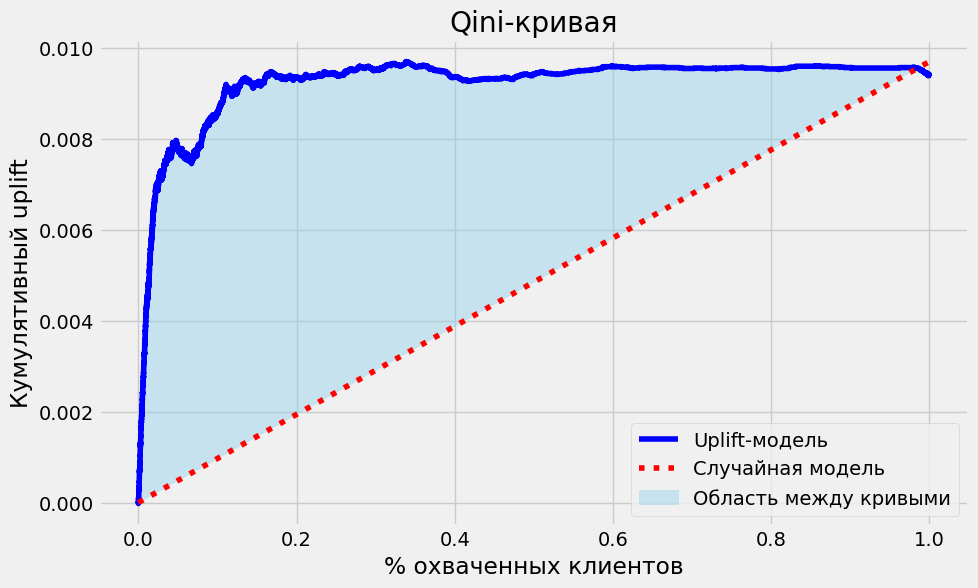

AUUC: 0.0044
Uplift@k: 0.0153


In [ ]:
uplift_score_auuc = calculate_qini_score(df=df_test, uplift_col='uplift_score', treatment_col=col_treatment, outcome_col=col_target)
print(f"AUUC: {uplift_score_auuc:.4f}")
# Пример использования функции
# df - DataFrame, содержащий столбцы с предсказанным uplift, признаком воздействия и outcome.
uplift_score_at_k= calculate_uplift_at_k(df=df_test, uplift_col='uplift_score', treatment_col=col_treatment, outcome_col=col_target, k=0.3)
print(f"Uplift@k: {uplift_score_at_k:.4f}")


### T-learner

#### T-learner base

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

class TLearner:
    def __init__(self, model_0, model_1):
        """
        Initialize T-Learner with two models.
        """
        self.model_0 = model_0 if model_0 else cb.CatBoostRegressor(verbose=0, random_state=42)
        self.model_1 = model_1 if model_1 else cb.CatBoostRegressor(verbose=0, random_state=42)

    def fit(self, X, y, treatment: str = 'treatment'):
        """
        Fit two models: one for control group, another for treatment group.

        :param X: Feature matrix
        :param treatment: Treatment indicator (1 for treatment, 0 for control)
        :param y: Target variable
        """
        X_control = X[X[treatment] == 0]
        y_control = y[y[treatment] == 0].drop(columns=treatment)
        X_treatment = X[X[treatment] == 1]
        y_treatment = y[y[treatment] == 1].drop(columns=treatment)

        self.model_0.fit(X_control, y_control)
        self.model_1.fit(X_treatment, y_treatment)

    def predict(self, X):
        """
        Predict the uplift (CATE).
        """
        mu_0 = self.model_0.predict(X)
        mu_1 = self.model_1.predict(X)
        uplift = mu_1 - mu_0
        return uplift

In [ ]:
from sklearn.model_selection import train_test_split

# df_train = data.loc[fit_sample_index]
# df_test = data.loc[val_sample_index]

from sklearn.linear_model import LogisticRegression

t_learner = TLearner(cb.CatBoostRegressor(verbose=0, random_state=42), cb.CatBoostRegressor(verbose=0, random_state=42))
t_learner.fit(X=df_train[cols_features + [col_treatment]],
              y=df_train[[col_target] + [col_treatment]], )

In [ ]:
df_test['uplift_score_T'] = t_learner.predict(df_test[cols_features + [col_treatment]])

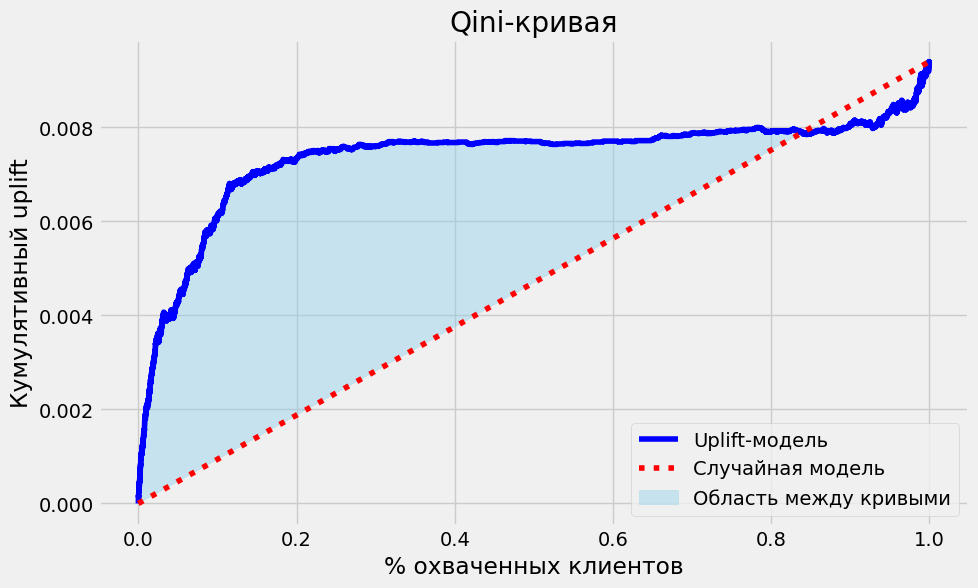

AUUC: 0.0027
Uplift@k: 0.0231


In [ ]:
uplift_score_auuc = calculate_qini_score(df=df_test, uplift_col='uplift_score_T', treatment_col=col_treatment, outcome_col=col_target)
print(f"AUUC: {uplift_score_auuc:.4f}")
# Пример использования функции
# df - DataFrame, содержащий столбцы с предсказанным uplift, признаком воздействия и outcome.
uplift_score_at_k= calculate_uplift_at_k(df=df_test, uplift_col='uplift_score_T', treatment_col=col_treatment, outcome_col=col_target, k=0.3)
print(f"Uplift@k: {uplift_score_at_k:.4f}")

#### T-learner CausalML

In [ ]:
import causalml.inference.meta.tlearner as tlearner

**Build model**

In [ ]:
model_n11 = tlearner.BaseTRegressor(
    learner=cb.CatBoostRegressor(verbose=0),
    control_name=0
)

In [ ]:
model_n11.fit(
    X=df_train.loc[fit_index, cols_features].values,
    treatment=df_train.loc[fit_index, col_treatment].values,
    y=df_train.loc[fit_index, 'visit'].values,
)

In [ ]:
df_test = df_train.loc[val_sample_index]

df_test['uplift_score_Tf'] = model_n11.predict(df_test[cols_features + [col_treatment]].values)

In [ ]:
calculate_qini_score(df=df_test, uplift_col='uplift_score_Tf', treatment_col=df_test[col_treatment], outcome_col=df_test[col_target])

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.351733
Random    0.000000
dtype: float64

### X-learner

#### X-learner base

In [ ]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

class XLearner:
    def __init__(self, model_0=None, model_1=None, model_tau_0=None, model_tau_1=None):
        """
        Initialize X-Learner with models.
        """
        self.model_0 = model_0 if model_0 else CatBoostRegressor(verbose=0)
        self.model_1 = model_1 if model_1 else CatBoostRegressor(verbose=0)
        self.model_tau_0 = model_tau_0 if model_tau_0 else CatBoostRegressor(verbose=0)
        self.model_tau_1 = model_tau_1 if model_tau_1 else CatBoostRegressor(verbose=0)

    def fit(self, X, y, treatment_col: str = 'treatment'):
        """
        Fit two models: one for control group, another for treatment group.
        """
        X_control = X[X[treatment_col] == 0]
        y_control = y[y[treatment_col] == 0].drop(columns='treatment')
        X_treatment = X[X[treatment_col] == 1]
        y_treatment = y[y[treatment_col] == 1].drop(columns='treatment')

        # Fit models on control and treatment groups
        self.model_0.fit(X_control, y_control)
        self.model_1.fit(X_treatment, y_treatment)

        # Predict on both groups
        mu_0_treatment = self.model_0.predict(X_treatment)
        mu_1_control = self.model_1.predict(X_control)

        D_treatment = pd.DataFrame()
        D_control = pd.DataFrame()

        D_treatment['y_treatment'] = y_treatment
        D_control['y_control'] = y_control

        D_treatment['mu_0_treatment'] = mu_0_treatment
        D_control['mu_1_control'] = mu_1_control

        D_treatment['D_treatment'] = D_treatment['y_treatment'] - D_treatment['mu_0_treatment']
        D_control['D_control'] = D_control['y_control'] - D_control['mu_1_control']

        self.model_tau_0.fit(X_control, D_control['D_control'])
        self.model_tau_1.fit(X_treatment, D_treatment['D_treatment'])

    def predict(self, X, propensity_scores=None):
        """
        Predict the uplift (CATE).

        :param X: Feature matrix
        :param propensity_scores: Optional propensity scores
        :return: Uplift predictions
        """
        tau_0 = self.model_tau_0.predict(X)
        tau_1 = self.model_tau_1.predict(X)
        if propensity_scores is None:
            g_x = 0.85  # Balanced case
        else:
            g_x = propensity_scores

        uplift = g_x * tau_0 + (1 - g_x) * tau_1
        return uplift

In [ ]:
from sklearn.model_selection import train_test_split

# df_train = data.loc[fit_sample_index]
# df_test = data.loc[val_sample_index]

from sklearn.linear_model import LogisticRegression

x_learner = XLearner()
x_learner.fit(X=df_train[cols_features + [col_treatment]],
              y=df_train[[col_target] + [col_treatment]], )


In [ ]:
df_test['uplift_score_X'] = x_learner.predict(df_test[cols_features + [col_treatment]])

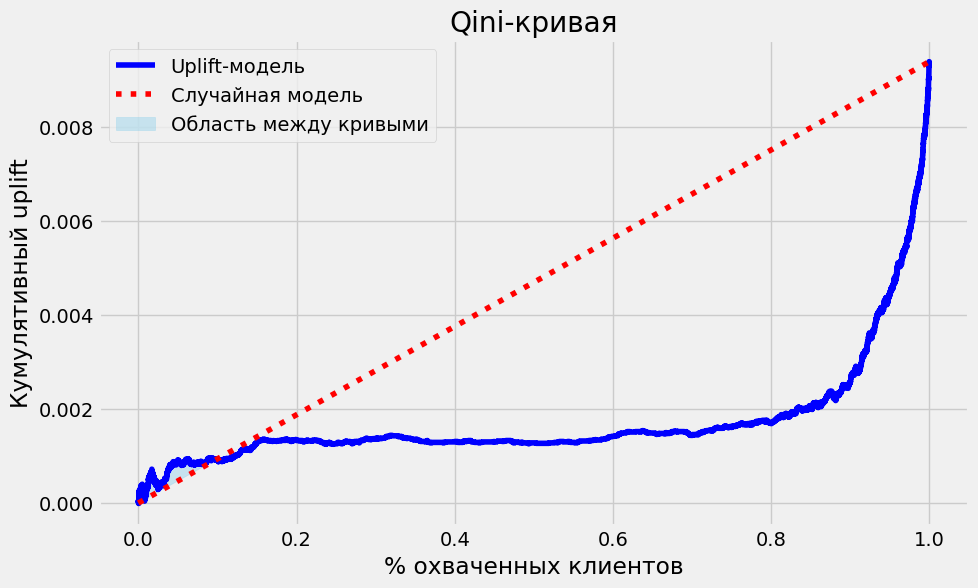

AUUC: -0.0030
Uplift@k: 0.0055


In [ ]:
uplift_score_auuc = calculate_qini_score(df=df_test, uplift_col='uplift_score_X', treatment_col=col_treatment, outcome_col=col_target)
print(f"AUUC: {uplift_score_auuc:.4f}")
# Пример использования функции
# df - DataFrame, содержащий столбцы с предсказанным uplift, признаком воздействия и outcome.
uplift_score_at_k= calculate_uplift_at_k(df=df_test, uplift_col='uplift_score_X', treatment_col=col_treatment, outcome_col=col_target, k=0.3)
print(f"Uplift@k: {uplift_score_at_k:.4f}")

#### X-learner CausalML

In [ ]:
import causalml.inference.meta.xlearner as xlearner

In [ ]:
model_n4 = xlearner.BaseXRegressor(
    learner=cb.CatBoostRegressor(verbose=0),
    control_name=0
)

In [ ]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

In [ ]:
_p_score_const

0.8500528404219257

In [ ]:
model_n4.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values, # .apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data.loc[fit_index, 'visit'].values,
    p=_p_scores
)

In [ ]:
_p_scores = pd.Series(data=_p_score_const, index=val_index)

_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_n4.predict(_eval_data[cols_features], p=_p_scores)
_eval_data = _eval_data[['score', col_treatment, 'visit']]

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.02), bins=100)
plt.show()

NameError: name '_eval_data' is not defined

<Figure size 1000x600 with 0 Axes>

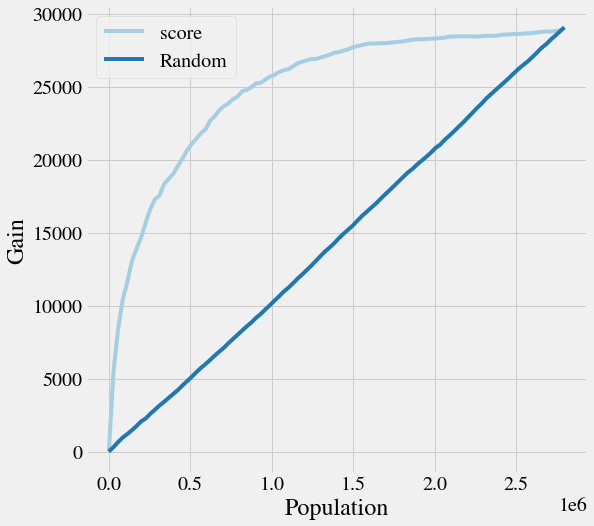

In [ ]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.856371
Random    0.497666
dtype: float64

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.362428
Random    0.000000
dtype: float64

### R-learner

#### R-learner base

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.base import clone

class RLearner:
    def __init__(self, n_splits=5, catboost_params=None):
        self.n_splits = n_splits
        if catboost_params is None:
            self.catboost_params = {
                'iterations': 1000,
                'learning_rate': 0.1,
                'depth': 6,
                'random_state': 42,
                'silent': True
            }
        else:
            self.catboost_params = catboost_params
        self.mu_models = []
        self.e_models = []
        self.tau_model = None

    def fit(self, X, y, t):
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        mu_models = []
        e_models = []

        # Train mu and e models on each fold
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.loc[train_index], X.loc[val_index]
            y_train, y_val = y.loc[train_index], y.loc[val_index]
            t_train, t_val = t.loc[train_index], t.loc[val_index]

            mu_model = CatBoostRegressor(**self.catboost_params)
            mu_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
            mu_models.append(mu_model)

            e_model = CatBoostRegressor(**self.catboost_params)
            e_model.fit(X_train, t_train, eval_set=(X_val, t_val), verbose=False)
            e_models.append(e_model)

        # your code here
        self.mu_models = mu_models
        self.e_models = e_models

        # Predict mu and e for all data points using out-of-fold predictions
        mu_hat = np.zeros_like(y)
        e_hat = np.zeros_like(t)

        for i, (train_index, val_index) in enumerate(kf.split(X)):
            mu_hat[val_index] = mu_models[i].predict(X.loc[val_index])
            e_hat[val_index] = e_models[i].predict(X.loc[val_index])

        pseudo_outcome = (y - mu_hat) / (t - e_hat)
        mask = (t - e_hat) != 0  # Avoid division by zero

        # Train tau model on the pseudo-outcome
        self.tau_model = CatBoostRegressor(**self.catboost_params)
        self.tau_model.fit(X[mask], pseudo_outcome[mask])

    def predict(self, X):
        return self.tau_model.predict(X)

In [ ]:
X = df_train[cols_features].reset_index(drop=True)

In [ ]:
# df_train = data.loc[fit_sample_index].reset_index(drop=True)
# df_test = data.loc[val_sample_index].reset_index(drop=True)

r_learner = RLearner()
r_learner.fit(X=df_train[cols_features],
              y=df_train[col_target], t=df_train[col_treatment])


In [ ]:
df_test['uplift_score_R'] = r_learner.predict(df_test[cols_features])

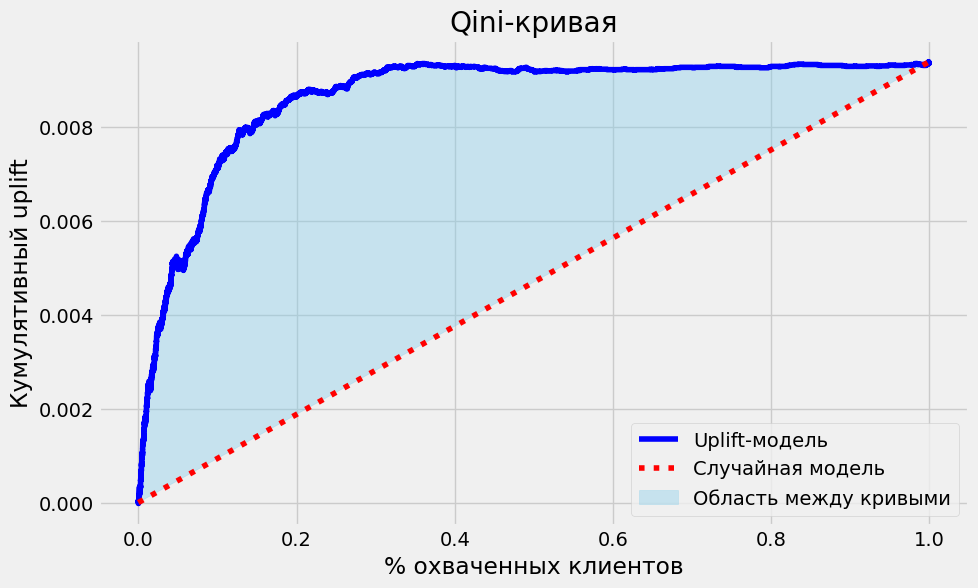

AUUC: 0.0039
Uplift@k: 0.0267


In [ ]:
uplift_score_auuc = calculate_qini_score(df=df_test, uplift_col='uplift_score_R', treatment_col=col_treatment, outcome_col=col_target)
print(f"AUUC: {uplift_score_auuc:.4f}")
# Пример использования функции
# df - DataFrame, содержащий столбцы с предсказанным uplift, признаком воздействия и outcome.
uplift_score_at_k= calculate_uplift_at_k(df=df_test, uplift_col='uplift_score_R', treatment_col=col_treatment, outcome_col=col_target, k=0.3)
print(f"Uplift@k: {uplift_score_at_k:.4f}")

#### R-learner CausalML

In [ ]:
import causalml.inference.meta.rlearner as rlearner

In [ ]:
model_rl = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0
)

In [ ]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_rl.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, 'visit'].values,
    p=_p_scores
)

In [ ]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'visit']]
_eval_data['score'] = model_rl.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, 'visit']]

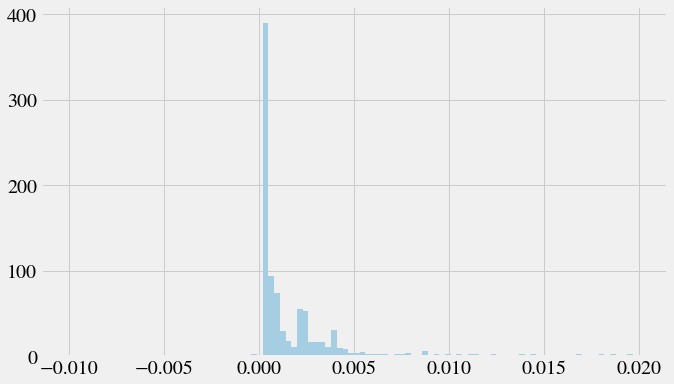

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'].head(1000), range=(-0.01, 0.02), bins=100)
plt.show()

In [ ]:
_eval_data['score'].describe()

count    2.795919e+06
mean     7.288603e-03
std      2.336141e-02
min     -6.323989e-01
25%      3.154303e-04
50%      7.979355e-04
75%      2.932799e-03
max      6.060000e-01
Name: score, dtype: float64

In [ ]:
np.percentile(_eval_data['score'], 95)

0.04211464221865127

In [ ]:
np.percentile(_eval_data['score'], 99)

0.12428524145941067

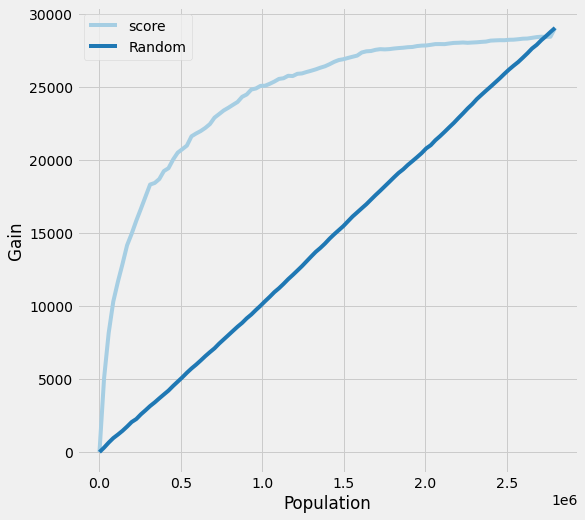

In [ ]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.840713
Random    0.497666
dtype: float64

In [ ]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col='visit',
)

score     0.346725
Random    0.000000
dtype: float64